In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

### 2. Load Clustering
---

In [4]:
n_clusters = 3

In [5]:
Xi_mice = pd.read_csv("data/imputed/mice_qvars_05.tsv", sep="\t", index_col=0).rename(
    columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

In [21]:
Xi_mice.shape

(2074, 28)

In [6]:
mice_05_ccp = pd.read_csv("data/clustering/mice_qvars_05/item_consensus.tsv", sep='\t')

# Filter by n clusters
mice_05_ccp = mice_05_ccp[mice_05_ccp['k']==n_clusters]
mice_05_ccp = mice_05_ccp.loc[
    mice_05_ccp.groupby('item')['itemConsensus'].idxmax(),
    ['item','cluster','itemConsensus']
]

mice_05_ccp = mice_05_ccp.rename(columns={'item':'Code_ID'}).set_index("Code_ID")

In [7]:
mice_05_ccp.groupby('cluster').size(), mice_05_ccp.groupby('cluster').mean()

(cluster
 1    713
 2    830
 3    531
 dtype: int64,
          itemConsensus
 cluster               
 1             0.686397
 2             0.781891
 3             0.689758)

In [8]:
data_df = data_df.join(mice_05_ccp)
#data_df.rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t")

### 3. Run Enrichments
---

In [9]:
# Comparison for Numeric
qvars = np.array(Xi_mice.columns)

# Run rank-sum tests
contrasts_df = utils.get_contrasts(data_df, "cluster", qvars)
# contrasts_df.to_csv("data/clustering/mice_qvars_05/contrasts_qvars.tsv", sep="\t")

100%|██████████| 3/3 [00:00<00:00, 22.72it/s]


In [10]:
# Fisher Exact for Categoricals
from sksurv.preprocessing import OneHotEncoder

# Comparison for Categoricals
# Drop due to high missingness
to_drop = ["Age","Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education", "Abdominal fat pad CR staining", "Bone marrow CR staining"]

catvars = list(set(amyloid.catvars)-set(to_drop))

# If uncertain or equivocal, do not include in fisher exact
_cat_df = data_df[catvars].replace({
    "uncertain":np.nan,
    "equivocal":np.nan,
    "involved":"yes",
    "not_involved":"no"})

_cat_df["Race"] = _cat_df["Race"].apply(lambda x: "Other" if x in ['Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'] else x)
_cat_df = _cat_df.astype("category")

# Collapse Race
_cat_df = OneHotEncoder().fit_transform(_cat_df)

contrasts_fe_df = utils.fisher_exact(_cat_df, data_df["cluster"])
contrasts_fe_df['feat'] = contrasts_fe_df['feat'].str.replace("=yes","")
#contrasts_fe_df.to_csv("data/clustering/mice_qvars_05/contrasts_fe.tsv", sep="\t")

### 4. Pincipal Components Analysis
---

Can perform this either:
* With imputed data
* With probabalistic PCA (`ppca`), in exploration

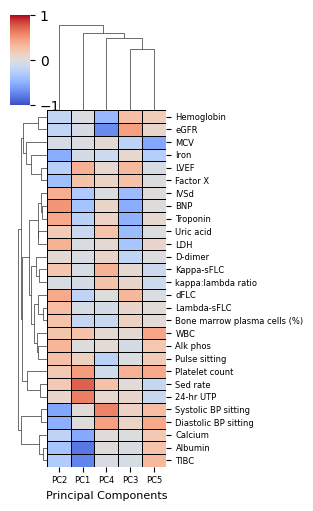

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Using MICE imputed
P_df, pca, pca_vars = utils.get_pcs(Xi_mice)

# Correlation between variables and PCs
plot.plot_clustermap(
    P_df.join(Xi_mice).corr('spearman').loc[Xi_mice.columns, P_df.columns].rename(columns={0:"PC1",1:"PC2",2:"PC3",3:"PC4",4:"PC5"}),
    figsize=(4,5),
    xlabel='Principal Components'
)

plt.savefig("figures/mice_imputed_pca_corr.pdf", dpi=200, bbox_inches="tight")

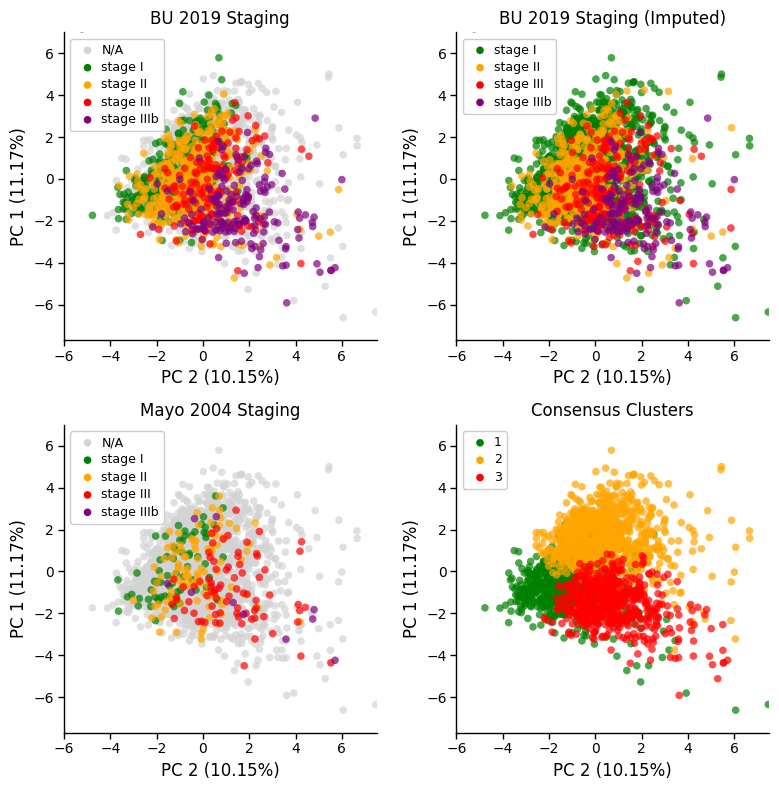

In [118]:
fig,axes = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

alpha=0.7
xlim=(None,7.5)
ylim=(None,7)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[0,0], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index,:].apply(lambda row: utils.assign_bu_stage(row), 1), 
                 ax=axes[0,1], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Mayo  2004 cardiac biomarker staging"].fillna("N/A"), 
                 ax=axes[1,0], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index,"cluster"].astype(int), 
                 ax=axes[1,1], 
                 cohort_colors={1:"green",2:"orange",3:"red"},
                 xlim=xlim, ylim=ylim, alpha=alpha
                 )

axes[0,0].set_title("BU 2019 Staging")
axes[0,1].set_title("BU 2019 Staging (Imputed)")
axes[1,0].set_title("Mayo 2004 Staging")
axes[1,1].set_title("Consensus Clusters")
plt.tight_layout()

plt.savefig("figures/mice_pca_staging.pdf", dpi=200, bbox_inches="tight")

/var/folders/m0/69jv0yz94wd23rxxdwwkcn9w0000gp/T/ipykernel_56552/3208939096.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


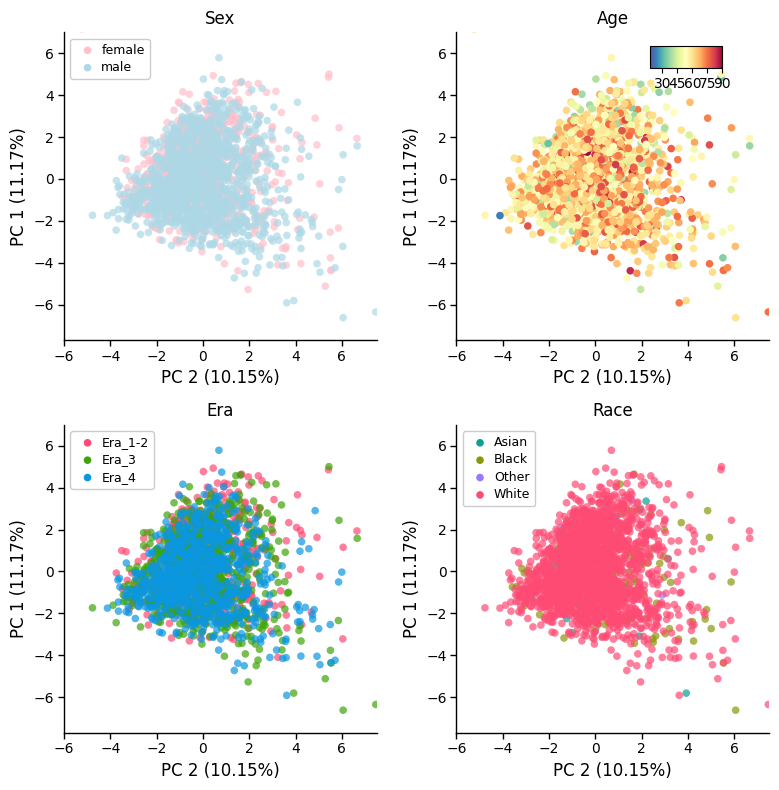

In [114]:
fig,axes = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

alpha=0.7
xlim=(None,7.5)
ylim=(None,7)

plot.plot_pca_ax(P_df, pca, c=data_df.loc[P_df.index, "Age"], ax=axes[0,1], xlim=xlim, ylim=ylim)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Sex"], ax=axes[0,0], xlim=xlim, ylim=ylim, cohort_colors={"female":"pink","male":"lightblue"}, alpha=alpha)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Era"], ax=axes[1,0], xlim=xlim, ylim=ylim, alpha=alpha)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Race"].apply(
                lambda x: "Other" if x in ['American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'] else x),
                 ax=axes[1,1], xlim=xlim, ylim=ylim, alpha=alpha)

axes[0,0].set_title("Sex")
axes[0,1].set_title("Age")
axes[1,0].set_title("Era")
axes[1,1].set_title("Race")

plt.tight_layout()
plt.savefig("figures/mice_pca_demo.pdf", dpi=200, bbox_inches="tight")


/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


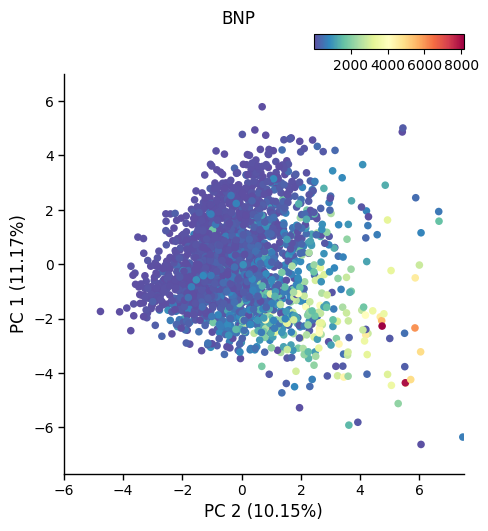

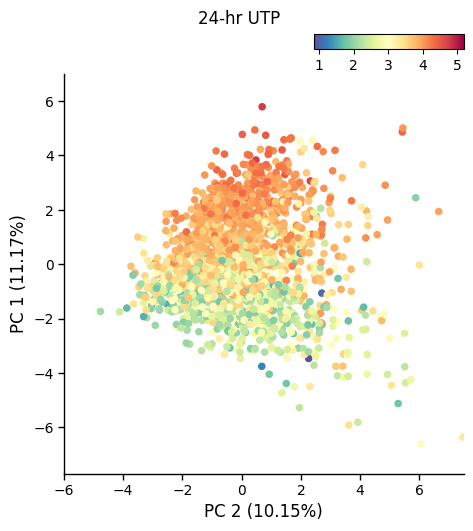

In [116]:
_ = plot.plot_pca(
    P_df,
    pca,
    c=Xi_mice.loc[P_df.index, "BNP"],
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title="BNP"
)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "24-hr UTP"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "24-hr UTP"
)

### 5. Probablistic PCA
---
* In exploration

In [123]:
def get_ppca(X_df: pd.DataFrame, normalize:bool=True):
    """Get Probablistic PCA

    Args:
        X (pd.DataFrame): _description_
        normalize (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    from ppca import PPCA
    import scipy
    from sklearn.preprocessing import StandardScaler

    if normalize:
        X = StandardScaler().fit_transform(X_df.values)
    else:
        X = X_df.values
    
    ppca = PPCA()
    ppca.fit(X, d=100, verbose=False)

    P_df = pd.DataFrame(ppca.data, index=X_df.index, columns=range(ppca.data.shape[1]))
    ppca.explained_variance_ratio_ = ppca.var_exp

    return P_df, ppca

ppca_df, ppca = get_ppca(data_df.loc[Xi_mice.index,Xi_mice.columns])